In [ ]:
links = {}
url = f'https://www.beeradvocate.com/beer/styles/'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
divs = soup.find_all('div', class_='stylebreak')
for div in divs:
  group_name = div.find_all('b')[0].text
  lis = div.find_all('li')
  for li in lis:
    token = li.find_all('a', href=True)[0]
    link = f"https://www.beeradvocate.com{token['href']}"
    name = token.text

    links[name] = [link, group_name]

In [ ]:
full_information = []

for beer_type in tqdm(links, total=len(links)): # all beer types

  for page in [0, 50, 100, 150]:
    url = f"{links[beer_type][0]}?sort=revsD&start={page}"
    group_name = links[beer_type][1]
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    tds = soup.find_all('td', class_='hr_bottom_light')

    for i in range(len(tds)): # all beers of choosen type
      if i%6 == 0:
        company = tds[i].find_all('a')[1].text
        name = tds[i].find_all('a')[0].text

        profile_link = f"https://www.beeradvocate.com{tds[i].find_all('a')[0]['href']}"
        resp = requests.get(profile_link)
        s = BeautifulSoup(resp.text, 'lxml')

        info = {} # all current beer info

        info['Name:'] = name 
        info['Group:'] = group_name

        dl = s.find_all('dl', class_='beerstats')[0]
        dts = dl.find_all('dt') 
        dds = dl.find_all('dd')

        for i in range(len(dts)):
          col = dts[i].text

          if i == 1:
            col = 'Region:'

          t = re.sub('\n|\xa0', '', dds[i].text)
          t = re.sub('Ranked \#[0-9,]+$', '', t)
          info[col] = t

        all_com_info = []
        all_rate_info = []

        comments = s.find_all('div', class_='user-comment')

        for comm in comments: # all comment for current beer
          rate = comm.find_all('span', class_='BAscore_norm')

          if rate:          
            text_review = comm.find_all('div', style="margin:20px 0px; font-size:11pt; line-height:1.4;")[0].text

            all_com_info.append(text_review)
            all_rate_info.append(rate[0].text)

        info['Reviews:'] = all_com_info
        info['Rates:'] = all_rate_info
        full_information.append(info)


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
data = {k:[] for k in full_information[0].keys()}

for beer in full_information:
  for i in range(len(beer['Reviews:'])):
    ks = beer.keys()
    for k in ks:
      if k != 'Reviews:' and k != 'Rates:':
        data[k].append(beer[k])
    data['Reviews:'].append(beer['Reviews:'][i])
    data['Rates:'].append(beer['Rates:'][i])


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df = df[['Name:', 'From:', 'Group:', 'Region:', 'Style:', 'ABV:', 'Avg:', 'Reviews:', 'Rates:']]

In [ ]:
df.rename(columns={'From:':'Company',
                   'Name:':'Name',
                   'Group:':'Group',
                   'Region:':'Region',
                   'Style:':'Style',
                   'ABV:':'ABV',
                   'Avg:':'Avg',
                   'Reviews:':'Review',
                   'Rates':'Rate'}, inplace=True)

In [ ]:
df.Avg = df.Avg.map(lambda x: re.sub(' \| .*$', '', x))

In [ ]:
df.to_csv('/content/drive/MyDrive/nnlp_project/beer_df_large.csv', sep='\t', encoding='utf-8', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/nnlp_project/beer_df_large.csv', sep='\t', encoding='utf-8')

print(f"Shape: {df.shape}\nColumns: {', '.join(df.columns.to_list())}")

Shape: (174684, 9)

Columns: Name, Company, Group, Region, Style, ABV, Avg, Review, Rate


In [ ]:
df.head(2)

,Name,Company,Group,Region,Style,ABV,Avg,Review,Rate
0,Shiner Bock,Spoetzl Brewery,Bocks,"Texas, United States",Bock,4.5%,3.21,From a 12oz bottle into a cocktail glass.\n\nC...,3.66
1,Shiner Bock,Spoetzl Brewery,Bocks,"Texas, United States",Bock,4.5%,3.21,"Great relaxing beer. Very mellow, great taste-...",4.10


In [ ]:
df = df[df.Review.notna()]

In [ ]:
df['Group'].value_counts()

Pale Lagers        26816
Pale Ales          23130
Strong Ales        20756
Stouts             16739
India Pale Ales    14166
Wild/Sour Beers    13324
Specialty Beers    12199
Dark Lagers        12173
Porters             9504
Wheat Beers         8469
Brown Ales          6987
Bocks               5816
Dark Ales           4605
Name: Group, dtype: int64

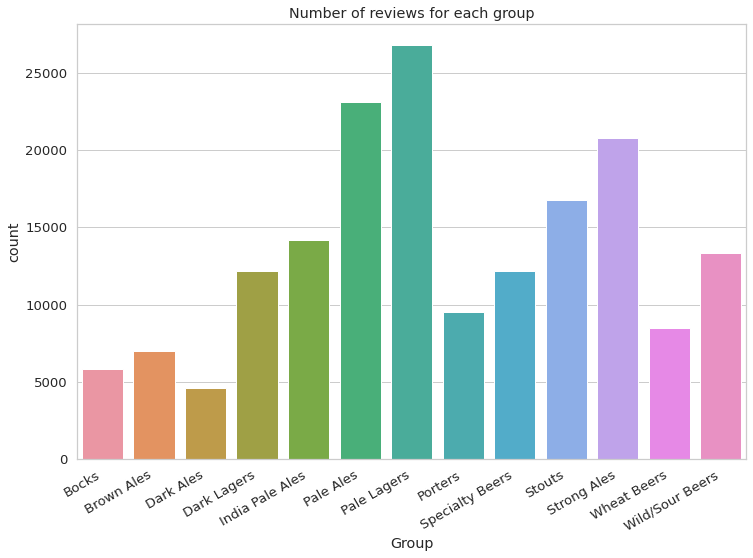

In [ ]:
chart = sns.countplot(df.Group)
plt.title("Number of reviews for each group")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
sampled = pd.DataFrame()
max_len = 10000

for name, i in df.Group.value_counts().iteritems():
    if i > max_len:
        temp_df = df[df.Group == name]
        temp_df = shuffle(temp_df, random_state=1337)
        temp_df = temp_df.iloc[0:max_len]
        sampled = sampled.append(temp_df)
    else:
        sampled = sampled.append(df[df.Group == name])

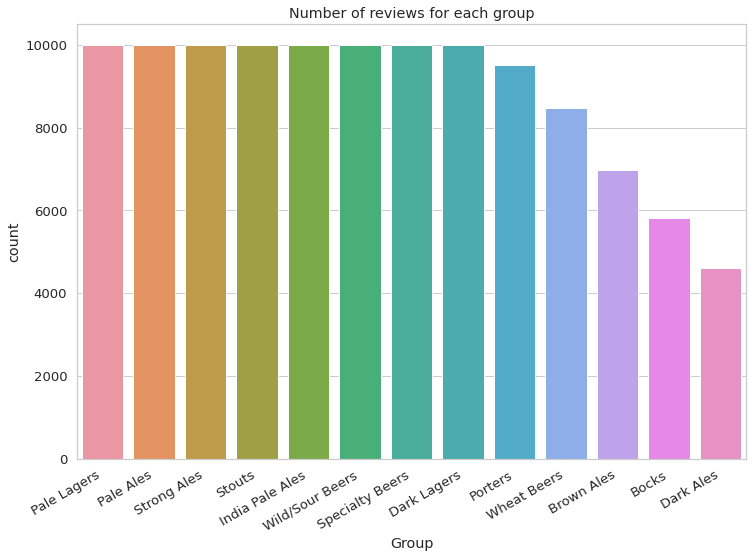

In [ ]:
chart = sns.countplot(sampled.Group)
plt.title("Number of reviews for each group")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
sampled.head()

,Name,Company,Group,Region,Style,ABV,Avg,Review,Rate
68715,Regia Extra,Cerveceria La Constancia S.A. / BevCo Ltd,Pale Lagers,El Salvador,American Adjunct Lager,5.3%,3.11,"Good take on an adjunct lager. Smooth, easy to...",3.89
74159,Costa Kick Plastic Pilsner,SweetWater Brewing Company,Pale Lagers,"Georgia, United States",Bohemian / Czech Pilsner,5.3%,3.74,Pours a really nice dark gold with inch of whi...,3.94
73575,Red Racer Pilsner,Central City Brewers + Distillers,Pale Lagers,"British Columbia, Canada",Bohemian / Czech Pilsner,5%,3.59,A: Transparent pale yellow and a frothy white ...,3.52
75712,Ovce 12º,Cohesion Brewing,Pale Lagers,"Colorado, United States",Czech Pale Lager,4.8%,4.06,L: Pours a slightly cloudy yellow orange color...,4.37
86214,Helles Lager,Tivoli Brewing Company,Pale Lagers,"Colorado, United States",Helles,5.1%,3.69,12oz can stamped 04/16/20 (assuming canned on ...,3.58


In [ ]:
gr, mean_l = [], []
for g in sampled.Group.unique():
  mean_l.append(mean(df[df.Group==g].Review.map(lambda x: len(str(x)))))
  gr.append(g)

<AxesSubplot:xlabel='Group', ylabel='Mean review length'>

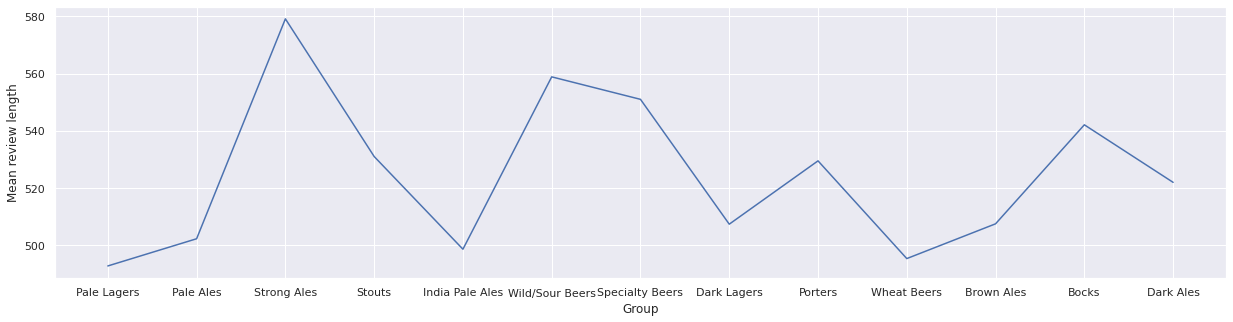

In [ ]:
sns.set(rc={'figure.figsize':(21,5)})

sns.lineplot(
    x='Group', 
    y='Mean review length',
    data=pd.DataFrame({'Group': gr, 'Mean review length': mean_l}))

In [ ]:
print(f'Средняя длина отзыва: {round(mean(df.Review.map(lambda x: len(str(x)))))} слова')

Средняя длина отзыва: 524 слова


# Classification 1.

In [ ]:
!pip install transformers

In [1]:
from transformers import BertTokenizer
import torch
import numpy as np
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1bmr04biWB-NWRbRYbO3XBA33ltROqk47

In [2]:
df = pd.read_csv("beer_df_large.csv", sep="\t")

In [3]:
df = df.drop(columns=['Name', 'Company', 'Region', 'ABV', 'Avg', 'Rate'])

In [4]:
df

,Group,Style,Review
0,Bocks,Bock,From a 12oz bottle into a cocktail glass.\n\nC...
1,Bocks,Bock,"Great relaxing beer. Very mellow, great taste-..."
2,Bocks,Bock,"Appearance: Clear, bright copper color. Frothy..."
3,Bocks,Bock,As a German staying for holidays in the US I c...
4,Bocks,Bock,I would guess this is Shiner's #1 beer. It's p...
...,...,...,...
174679,Wild/Sour Beers,Wild Ale,"A really well done, well balanced sour with an..."
174680,Wild/Sour Beers,Wild Ale,"22oz bottle. Poured out a slightly hazy, brigh..."
174681,Wild/Sour Beers,Wild Ale,"There's lots of apricot in this beer, just a t..."
174682,Wild/Sour Beers,Wild Ale,Poured from a 22oz bomber into my Drie de Font...


In [5]:
df['Review'] = df.apply(lambda x: 'Group: {}. Review: {}'.format(x['Group'], x['Review']), axis=1)
df = df.drop('Group', axis=1)

In [6]:
df

,Style,Review
0,Bock,Group: Bocks. Review: From a 12oz bottle into ...
1,Bock,Group: Bocks. Review: Great relaxing beer. Ver...
2,Bock,"Group: Bocks. Review: Appearance: Clear, brigh..."
3,Bock,Group: Bocks. Review: As a German staying for ...
4,Bock,Group: Bocks. Review: I would guess this is Sh...
...,...,...
174679,Wild Ale,Group: Wild/Sour Beers. Review: A really well ...
174680,Wild Ale,Group: Wild/Sour Beers. Review: 22oz bottle. P...
174681,Wild Ale,Group: Wild/Sour Beers. Review: There's lots o...
174682,Wild Ale,Group: Wild/Sour Beers. Review: Poured from a ...


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [8]:
labels = {}
for i, name in enumerate(df['Style'].value_counts().index.tolist()):
  labels[name] = i

In [9]:
labels

{'American Adjunct Lager': 0,
 'Märzen': 1,
 'German Pilsner': 2,
 'European Pale Lager': 3,
 'American Lager': 4,
 'Helles': 5,
 'Russian Imperial Stout': 6,
 'American Imperial Stout': 7,
 'Bohemian / Czech Pilsner': 8,
 'Sweet / Milk Stout': 9,
 'Imperial IPA': 10,
 'Tripel': 11,
 'American Porter': 12,
 'American Stout': 13,
 'American IPA': 14,
 'English Pale Ale': 15,
 'Fruit and Field Beer': 16,
 'Oatmeal Stout': 17,
 'Hefeweizen': 18,
 'Belgian Pale Strong Ale': 19,
 'Pumpkin Beer': 20,
 'Belgian Dark Strong Ale': 21,
 'American Brown Ale': 22,
 'American Blonde Ale': 23,
 'New England IPA': 24,
 'Witbier': 25,
 'Saison': 26,
 'American Pale Ale': 27,
 'Kölsch': 28,
 'English Barleywine': 29,
 'American Amber / Red Ale': 30,
 'American Pale Wheat Beer': 31,
 'Imperial Porter': 32,
 'Wild Ale': 33,
 'American Barleywine': 34,
 'Gose': 35,
 'Scotch Ale / Wee Heavy': 36,
 'Fruited Kettle Sour': 37,
 'Light Lager': 38,
 'Doppelbock': 39,
 'Winter Warmer': 40,
 'Berliner Weisse': 41

In [10]:
len(labels)

116

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['Style']]
        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = 512, 
                                truncation=True, 
                                return_tensors="pt") 
                      for text in df['Review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [12]:
np.random.seed(42)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

139747 17468 17469


In [13]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 116)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

In [14]:
def train(model, train_data, val_data, learning_rate, epochs):
    print('Loading data into a dataset...')

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)
    print('Data loaded')

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [15]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading data into a dataset...
Data loaded


100%|██████████| 17469/17469 [57:08<00:00,  5.09it/s]


Epochs: 1 | Train Loss:  0.417                 | Train Accuracy:  0.173                 | Val Loss:  0.332                 | Val Accuracy:  0.224


100%|██████████| 17469/17469 [56:56<00:00,  5.11it/s]


Epochs: 2 | Train Loss:  0.296                 | Train Accuracy:  0.283                 | Val Loss:  0.269                 | Val Accuracy:  0.339


100%|██████████| 17469/17469 [56:42<00:00,  5.13it/s]


Epochs: 3 | Train Loss:  0.245                 | Train Accuracy:  0.393                 | Val Loss:  0.231                 | Val Accuracy:  0.429


100%|██████████| 17469/17469 [56:39<00:00,  5.14it/s]


Epochs: 4 | Train Loss:  0.214                 | Train Accuracy:  0.465                 | Val Loss:  0.208                 | Val Accuracy:  0.476


100%|██████████| 17469/17469 [56:42<00:00,  5.13it/s]


Epochs: 5 | Train Loss:  0.194                 | Train Accuracy:  0.507                 | Val Loss:  0.193                 | Val Accuracy:  0.508


In [16]:
torch.save(model, 'beert_model_batch8_5epochs.pt')

In [17]:
def evaluate(model, test_data):
    y_pred = []
    y_true = []
    print('Loading data...')
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    print('Data loaded')

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    
    with torch.no_grad():
        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            y_pred.append(output.argmax(dim=1))
            y_true.append(test_label)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return y_pred, y_true
    

In [18]:
y_pred, y_true = evaluate(model, df_test)

Loading data...
Data loaded
Test Accuracy:  0.515


In [ ]:
import torch
load = torch.load('beert_model_simple.pt')

confusion matrix

In [32]:
t = [x.cpu() for x in y_true]

In [ ]:
classes = labels.keys()
cf_matrix = confusion_matrix([x.cpu() for x in y_true], [y.cpu() for y in y_pred])
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')